In [1]:
using LinearAlgebra
using Random
using Statistics
using Plots

In [2]:
# QR Decomposition using Householder from the LinearAlgebra package
function qr_(A)
    F = qr(A)

    Q = Matrix(F.Q)   # matriz Q construída com Householder
    R = F.R           # matriz triangular superior
    return Q, R
end



qr_ (generic function with 1 method)

In [3]:
# Função QR via Gram-Schmidt clássico
function gram_schmidt_qr(A)
    m, n = size(A)
    Q = zeros(Float64, m, n)
    R = zeros(Float64, n, n)

    for j in 1:n
        v = A[:, j]
        for i in 1:j-1
            R[i, j] = Q[:, i]' * A[:, j]
            v -= R[i, j] * Q[:, i]
        end
        R[j, j] = norm(v)
        Q[:, j] = v / R[j, j]
    end
    return Q, R
end

gram_schmidt_qr (generic function with 1 method)

In [4]:
function householder_qr(A)
    m, n = size(A)
    R = copy(A)                 # R vai ser transformada em matriz triangular superior
    Q = Matrix{Float64}(I, m, m)         # Começa como identidade, vai acumulando as reflexões

    for k = 1:min(m - 1, n)
        # 1. Extraímos o vetor da coluna atual a partir da linha k
        x = R[k:end, k]

        # 2. Criamos o vetor v da reflexão de Householder
        e1 = zeros(length(x))
        e1[1] = 1.0
        v = x + sign(x[1]) * norm(x) * e1
        v /= norm(v)

        # 3. Construímos a matriz de reflexão Hk (compacta)
        Hk = Matrix{Float64}(I, m, m)
        Hk[k:end, k:end] .-= 2 * (v * v')   # Atualiza só a submatriz

        # 4. Aplica Hk a R (Hk * R)
        R = Hk * R

        # 5. Acumula a transformação em Q
        Q = Q * Hk
    end

    return Q, R
end


householder_qr (generic function with 1 method)

In [5]:

function Print_resultados(A, Q, R)
    m, n = size(A)
    # Exibindo os resultados
    println("Matriz Q:", Q)
    println("Matriz R:", R)


    # Erro relativo da decomposição (QR ≈ A)
    erro_qr = norm(Q * R - A) / norm(A)

    # Verificação de ortogonalidade (QᵗQ ≈ I)
    erro_ortogonalidade = norm(Matrix{Float64}(I, m, m) - Q' * Q)

    # Erro de máquina
    ϵ = eps(Float64)

    # Resultados
    println("Erro relativo QR ≈ A:", erro_qr)
    println("Erro de ortogonalidade QᵗQ ≈ I:", erro_ortogonalidade)
    println("Erro da máquina: ", ϵ)

    println("\nQR é preciso? ", erro_qr < ϵ * 100)
    println("Q é ortogonal? ", erro_ortogonalidade < ϵ * 100)
end

Print_resultados (generic function with 1 method)

In [6]:
# Aplicar QR pela função do pacote LinearAlgebra
A=rand(3, 3) # matriz aleatória 3x3
Q, R = qr_(A)
Print_resultados(A,Q,R)

Matriz Q:[-0.3738705066533259 -0.07267059171571177 -0.9246295633141273; -0.9040865159674145 -0.19394267900683304 0.3808067868428219; -0.2069985891272868 0.9783175467910922 0.006808945584439785]
Matriz R:[-0.9254384574040941 -0.5635151368018697 -0.5947549031010279; 0.0 0.7226197125216294 0.6871677639069919; 0.0 0.0 -0.27270649382574075]
Erro relativo QR ≈ A:1.739638254677209e-16
Erro de ortogonalidade QᵗQ ≈ I:1.7469642988019156e-16
Erro da máquina: 2.220446049250313e-16

QR é preciso? true
Q é ortogonal? true


In [7]:
# Aplicar QR via Gram-Schmidt
Qg, Rg = gram_schmidt_qr(A)
Print_resultados(A,Qg,Rg)

Matriz Q:[0.37387050665332583 -0.0726705917157117 0.9246295633141272; 0.9040865159674144 -0.1939426790068328 -0.3808067868428222; 0.2069985891272868 0.9783175467910923 -0.0068089455844404755]
Matriz R:[0.9254384574040943 0.5635151368018697 0.594754903101028; 0.0 0.7226197125216293 0.687167763906992; 0.0 0.0 0.27270649382574086]
Erro relativo QR ≈ A:0.0
Erro de ortogonalidade QᵗQ ≈ I:1.357070562168549e-15
Erro da máquina: 2.220446049250313e-16

QR é preciso? true
Q é ortogonal? true


In [8]:
# QR Decomposition using Householder reflections
Qh, Rh = householder_qr(A)
Print_resultados(A,Qh,Rh)

Matriz Q:[-0.3738705066533259 -0.07267059171571208 -0.9246295633141269; -0.9040865159674145 -0.19394267900683282 0.38080678684282177; -0.20699858912728678 0.9783175467910917 0.006808945584439979]
Matriz R:[-0.9254384574040941 -0.5635151368018697 -0.594754903101028; 4.731093609702715e-17 0.722619712521629 0.6871677639069914; 5.95944814637827e-17 2.498001805406602e-16 -0.2727064938257406]
Erro relativo QR ≈ A:7.718638788564444e-16
Erro de ortogonalidade QᵗQ ≈ I:1.556769712416418e-15
Erro da máquina: 2.220446049250313e-16

QR é preciso? true
Q é ortogonal? true


In [9]:
function registrar_erros_qr(A, Q, R, id_alg, c)
    m, n = size(A)

    # Erro relativo da decomposição (QR ≈ A)
    erro_qr = norm(Q * R - A) / norm(A)

    # Verificação de ortogonalidade (QᵗQ ≈ I)
    erro_ortogonalidade = norm(Matrix(I, m, m) - Q' * Q)

    # Verificação de triangularidade superior de R (parte inferior ≈ 0)
    R_lower = tril(R, -1)  # Pega a parte estritamente inferior
    erro_triangularidade = norm(R_lower) / norm(R)  # Erro relativo

    # Erro de máquina
    ϵ = eps(Float64)

    # Atualiza vetores globais
    global qr_errors[id_alg] += erro_qr > ϵ * c
    global q_ortho_errors[id_alg] += erro_ortogonalidade > ϵ * c
    global r_triang_errors[id_alg] += erro_triangularidade > ϵ * c
end

function plot_error(N, m, c)
    # Vetores globais de contagem
    global qr_errors = [0, 0, 0]
    global q_ortho_errors = [0, 0, 0]
    global r_triang_errors = [0, 0, 0]  # Novo vetor para erros em R

    # Loop de N execuções para cada método
    for i in 1:N
        A = rand(m, m)  # Nova matriz aleatória

        # Método 1: QR de Julia (Householder interno)
        Q1, R1 = qr_(A)
        registrar_erros_qr(A, Q1, R1, 1, c)

        # Método 2: Gram-Schmidt
        Q2, R2 = gram_schmidt_qr(A)
        registrar_erros_qr(A, Q2, R2, 2, c)

        # Método 3: Householder implementado manualmente
        Q3, R3 = householder_qr(A)
        registrar_erros_qr(A, Q3, R3, 3, c)
    end

    # Função para formatar a saída com contagem e porcentagem
    function format_error(count)
        percentage = round(count / N * 100, digits=2)
        return "$count ($percentage%)"
    end

    # Exibe os resultados após as execuções
    println("Erros QR (decomposição ≠ A) em $N execuções:")
    println("QR padrão:        ", format_error(qr_errors[1]))
    println("Gram-Schmidt:     ", format_error(qr_errors[2]))
    println("Householder:      ", format_error(qr_errors[3]))

    println("\nErros de ortogonalidade (QᵗQ ≠ I) em $N execuções:")
    println("QR padrão:        ", format_error(q_ortho_errors[1]))
    println("Gram-Schmidt:     ", format_error(q_ortho_errors[2]))
    println("Householder:      ", format_error(q_ortho_errors[3]))

    println("Erros de triangularidade (R não é triangular) em $N execuções:")
    println("QR padrão:        ", format_error(r_triang_errors[1]))
    println("Gram-Schmidt:     ", format_error(r_triang_errors[2]))
    println("Householder:      ", format_error(r_triang_errors[3]))

    # Plotando os gráficos dos erros

    # Erros de decomposição (QR ≠ A)
    bar1 = bar([qr_errors[1], qr_errors[2], qr_errors[3]], label=["QR padrão", "Gram-Schmidt", "Householder"], title="Erros QR (decomposição ≠ A)", ylabel="Erro", xlabel="Métodos")

    # Erros de ortogonalidade (QᵗQ ≠ I)
    bar2 = bar([q_ortho_errors[1], q_ortho_errors[2], q_ortho_errors[3]], label=["QR padrão", "Gram-Schmidt", "Householder"], title="Erros de Ortogonalidade (QᵗQ ≠ I)", ylabel="Erro", xlabel="Métodos")

    # Erros de triangularidade (R não é triangular)
    bar3 = bar([r_triang_errors[1], r_triang_errors[2], r_triang_errors[3]], label=["QR padrão", "Gram-Schmidt", "Householder"], title="Erros de Triangularidade (R não é triangular)", ylabel="Erro", xlabel="Métodos")

    # Exibe os gráficos
    plot(bar1, bar2, bar3, layout=(3, 1), size=(1200, 900))
end

plot_error (generic function with 1 method)

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     3932 (3.93%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)


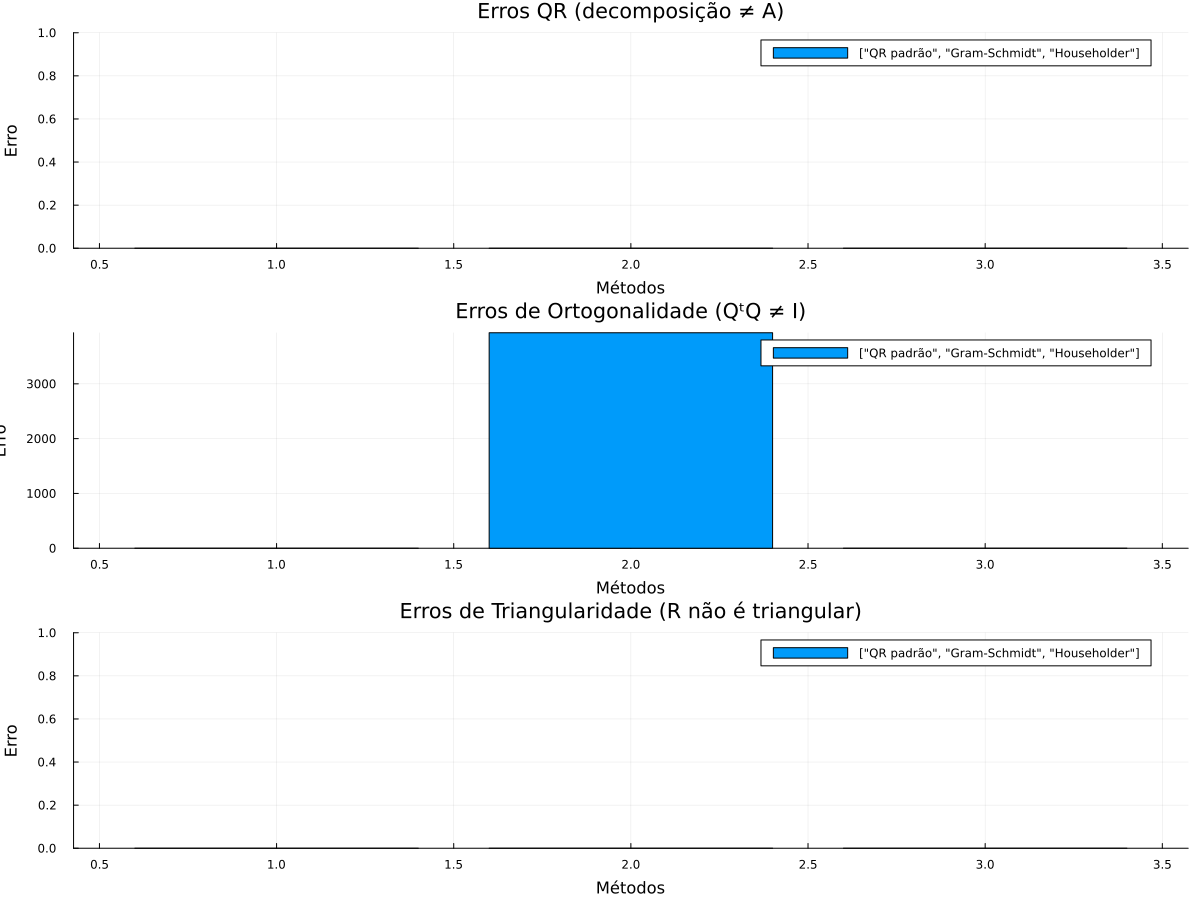

In [10]:
plot_error(100000, 3 , 100)

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     13670 (13.67%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)


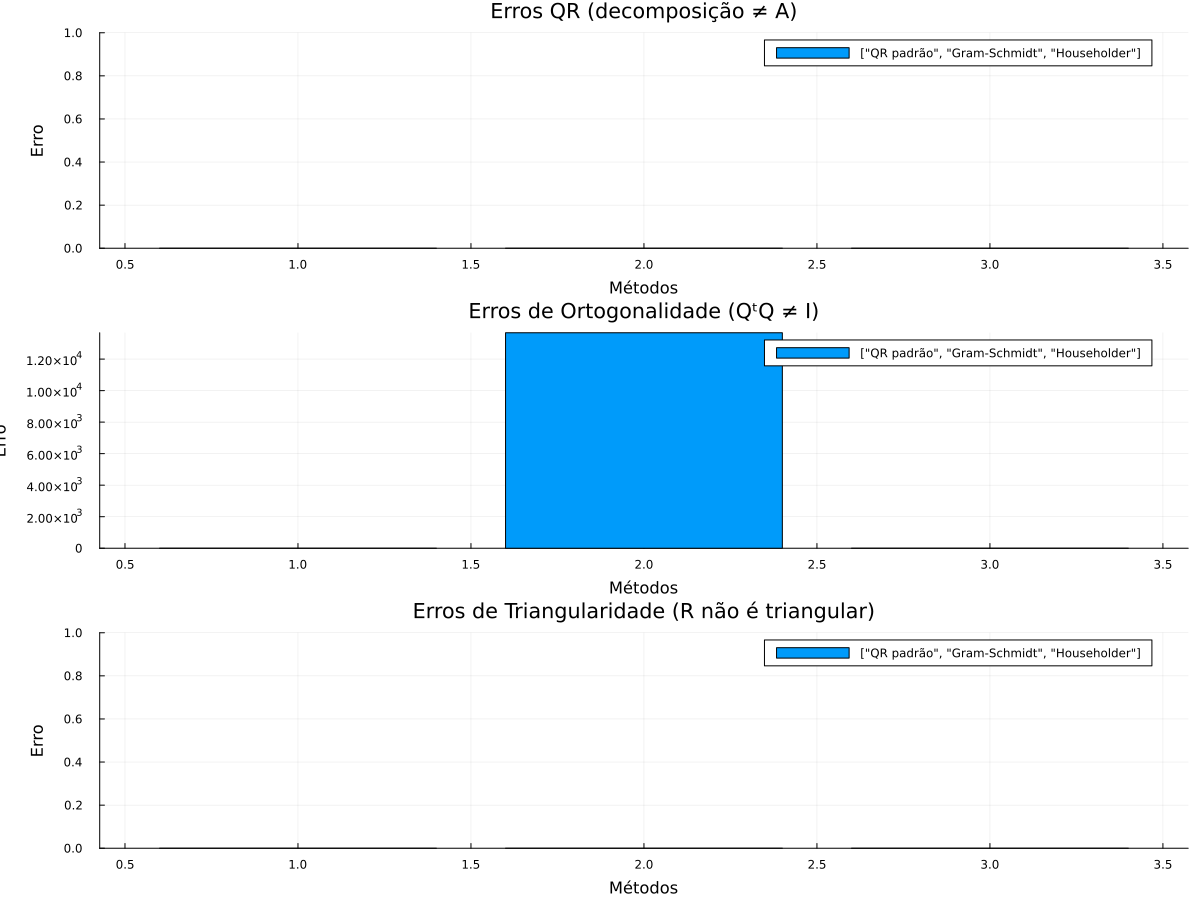

In [11]:
plot_error(100000, 5, 100)


Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     52757 (52.76%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)


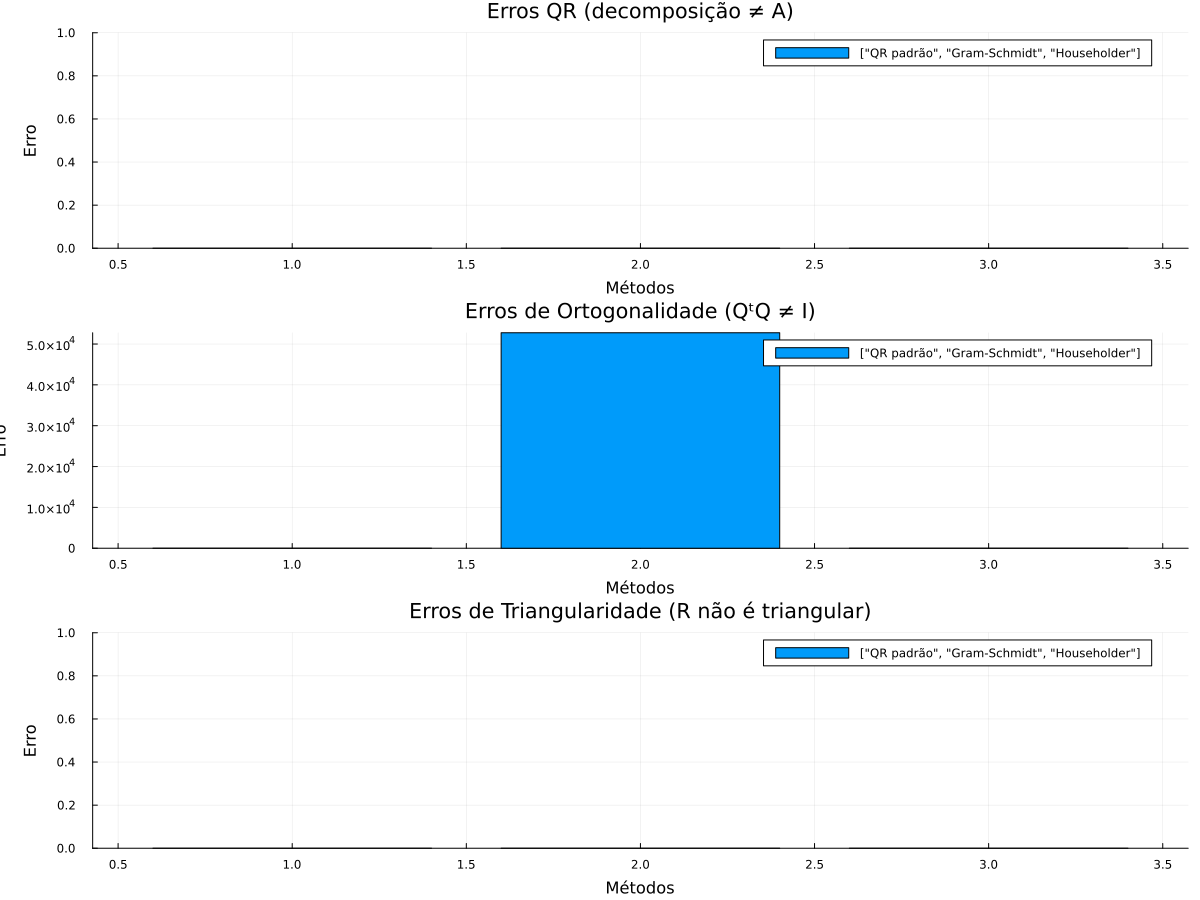

In [12]:

plot_error(100000, 10, 100)

In [13]:
function analyze_orthogonality_error(N, max_dim, c)
    
    # Arrays para armazenar os resultados
    dims = 1:max_dim
    errors_qr = zeros(max_dim)
    errors_gs = zeros(max_dim)
    errors_hh = zeros(max_dim)
    
    for d in dims
        # Reinicializa os contadores
        global q_ortho_errors = [0, 0, 0]
        
        # Executa os testes para esta dimensão
        plot_error(N, d, c)
        
        # Armazena as porcentagens de erro
        errors_qr[d] = q_ortho_errors[1]/N * 100
        errors_gs[d] = q_ortho_errors[2]/N * 100
        errors_hh[d] = q_ortho_errors[3]/N * 100
        
        println("Dimensão $d concluída")
    end
    
    # Plotando os resultados
    p = plot(dims, [errors_qr errors_gs errors_hh], 
             label=["QR Padrão" "Gram-Schmidt" "Householder"],
             xlabel="Dimensão da Matriz", 
             ylabel="Porcentagem de Erro de Ortogonalidade (%)",
             title="Evolução do Erro de Ortogonalidade por Dimensão com c=" * string(c),
             linewidth=2,
             markershape=:circle,
             markersize=4,
             legend=:topleft)
    
    display(p)
    
end


analyze_orthogonality_error (generic function with 1 method)

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 1 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     9752 (9.75%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 2 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (

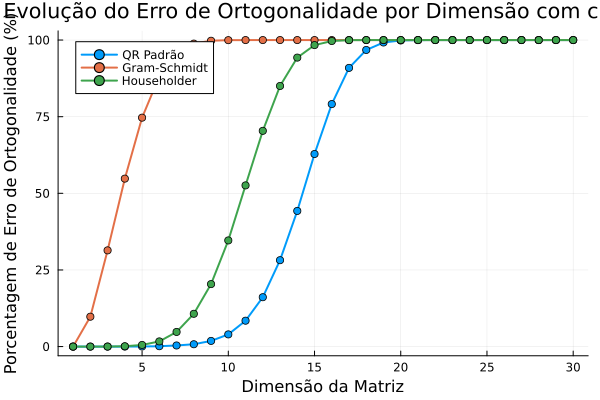

In [14]:
analyze_orthogonality_error(100000, 30, 10)

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 1 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     1055 (1.06%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 2 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (

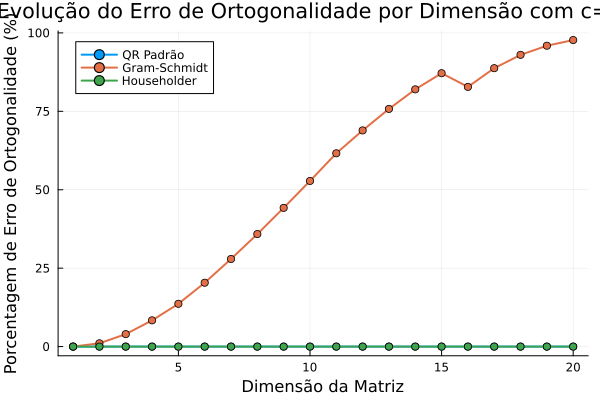

In [15]:
analyze_orthogonality_error(100000, 20, 100)